In [1]:
pwd

'/home/wsuser/work'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=a92199e85f97af0ad4cad03e1753b4b5e553e851d34d712c71f1185a6f0d6c7f
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/4b/a5/2d/4a070a801d3a3d93f033d3ee9728f470f514826e89952df3ea
Successfully built imutils


## Image Pre-processing

### Importing the necessary libraries

In [4]:
import cv2
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from skimage import feature
from imutils import paths
import os
import pickle

### Functions to load and quantify the images 

In [5]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='bnUtkeym3Aie3iBeWsaJiZT7Q0fxw_MgnerWhGNcboep',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'parkinsonsdetection-donotdelete-pr-mwspyvp55yhlq1'
object_key = 'dataset.zip'

streaming_body_2 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


In [7]:
from io import BytesIO
import zipfile
unzip = zipfile.ZipFile(BytesIO(streaming_body_2.read()),'r')
file_paths = unzip.namelist()
for path in file_paths:
    unzip.extract(path)

In [8]:
pwd

'/home/wsuser/work'

In [9]:
def quantify_image(image):
    features = feature.hog(image, 
                           orientations=9, 
                           pixels_per_cell=(5,5), 
                           cells_per_block=(2,2), 
                           transform_sqrt=True, 
                           block_norm="L1")
    return features

In [10]:
def load_split(path):
    path_images = list(paths.list_images(path))
    data=[]
    labels=[]

    for path_image in path_images:
        label = path_image.split(os.path.sep)[-2]
        image = cv2.imread(path_image)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200,200))
        image = cv2.threshold(image,0,225,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        features = quantify_image(image)
        data.append(features)
        labels.append(label)

    return (np.array(data), np.array(labels))


#### Using spiral images

### Defining the path for training data and testing data

In [25]:
path_training_data = r"/home/wsuser/work/dataset/spiral/training"
path_testing_data = r"/home/wsuser/work/dataset/spiral/testing"

### Loading the training and testing data

In [26]:
(x_train, y_train) = load_split(path_training_data)
(x_test, y_test) = load_split(path_testing_data)

### Label Encoding

In [27]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
print(x_train.shape, y_train.shape)
# 0:healthy,1:Parkinson

(72, 54756) (72,)


## Building the model

### Training the model

In [28]:
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)

RandomForestClassifier()

### Testing the model

In [29]:
testingPaths = list(paths.list_images(path_testing_data))
idxs = np.arange(0, len(testingPaths))
idxs = np.random.choice(idxs, size=(25,), replace=False) 
images = []

In [30]:
for i in idxs:
    # loading the testing image, clone it, and resize it 
    image = cv2.imread(testingPaths[i]) 
    output = image. copy() 
    output = cv2. resize(output, (128, 128))
    
    # pre-processing the image 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    image = cv2.resize(image, (200, 200))
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU) [1]
    
    # quantify the image and make predictions based on the extracted 
    # features using the last trained Random Forest 
    features = quantify_image(image) 
    preds = model.predict([features])

    label = label_encoder.inverse_transform(preds)[0]

    # draw the colored class label on the output image and add it to the set of output images 
    if label == "healthy":
        color = (0, 255, 0)  
    else:
        color = (0, 0, 255) 
    cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2) 
    images.append(output)

### Evaluating the model

[[11  4]
 [ 6  9]]
0.6666666666666666
Testing Sensitivity for Random Forest 0.6
Testing Specificity for Random Forest 0.7333333333333333
Testing Precision for Random Forest 0.6923076923076923
Testing accuracy for Random Forest 0.6666666666666666


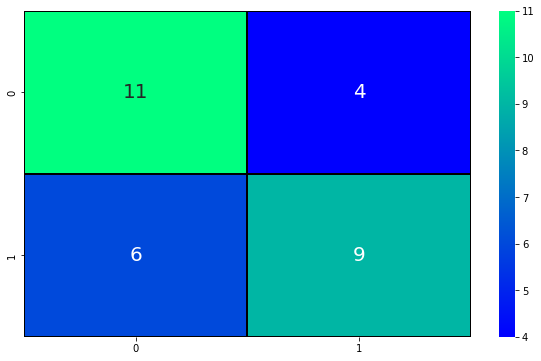

In [31]:
predictions = model.predict(x_test)    # predictions on the testing data 

cm = confusion_matrix(y_test, predictions)   # computing the confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True,cmap='winter',linewidths=0.3, linecolor='black',annot_kws={"size": 20})

print(cm) 
(TN, FP, FN, TP) = cm.flatten()

accuracy = (TP + TN) / float(cm.sum())     # computing the accuracy
print(accuracy)

print('Testing Sensitivity for Random Forest',(TP/(TP+FN)))
print('Testing Specificity for Random Forest',(TN/(TN+FP)))
print('Testing Precision for Random Forest',(TP/(TP+FP)))
print('Testing accuracy for Random Forest',accuracy_score(y_test, predictions))

In [32]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.65      0.73      0.69        15
           1       0.69      0.60      0.64        15

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.67      0.67      0.67        30



### Saving the model

In [33]:
pickle.dump(model,open('parkinson.pkl', 'wb'))

In [35]:
!tar -zcvf parkinsonsmodel.tgz parkinson.pkl

parkinson.pkl


In [36]:
ls

dataset/  parkinson.pkl  parkinsonsmodel.tgz


In [78]:
!pip install watson-machine-learning-client --upgrade

In [79]:
!pip install -U ibm-watson-machine-learning

In [80]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
                    "url" : "https://us-south.ml.cloud.ibm.com",
                    "apikey" : "9_NV6WjMkXK1YyDswn6CifrfHVpv6WzJzSDkedXQR9bH"
                    }

In [81]:
client = APIClient(wml_credentials)

In [82]:
client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  ----------------------  ------------------------
ID                                    NAME                    CREATED
4572c734-84dd-4550-a50c-e2178b21aa59  ParkinsonsDetectionDep  2022-11-17T11:06:27.808Z
------------------------------------  ----------------------  ------------------------


In [83]:
def guid_from_space_name(client,space_name):
    space = client.spaces.get_details()
#     print(space)
    return (next(item for item in space['resources'] if item['entity']['name']==space_name)['metadata']['id'])

In [85]:
space_id = guid_from_space_name(client,'ParkinsonsDetectionDep')
print('Space UID = ' + space_uid)

Space UID = 4572c734-84dd-4550-a50c-e2178b21aa59


In [86]:
client.set.default_space(space_id)

'SUCCESS'

In [87]:
client.software_specifications.list(500)

-------------------------------  ------------------------------------  ----
NAME                             ASSET_ID                              TYPE
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6            0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                       0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod     1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6                10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl        111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt

In [90]:
software_spec_uid=client.software_specifications.get_uid_by_name("runtime-22.1-py3.9") 
software_spec_uid

'12b83a17-24d8-5082-900f-0ab31fbfd3cb'

In [92]:
model_details = client.repository.store_model(model='parkinsonsmodel.tgz',meta_props={
client.repository.ModelMetaNames.NAME: "parkinson", 
client.repository.ModelMetaNames.TYPE: "scikit-learn_1.0", 
client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid})
model_id = client.repository.get_model_id(model_details)

In [93]:
DEPLOYMENT_NAME="ParkinsonsDetectionDep"
DEMO_MODEL=model

In [94]:
model_details
model_id=client.repository.get_model_id(model_details)
dep_props={
 client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME,
 client.deployments.ConfigurationMetaNames.ONLINE:{}
}

In [95]:
deployment=client.deployments.create(artifact_uid=model_id,meta_props=dep_props)



#######################################################################################

Synchronous deployment creation for uid: '8c4254c5-1a33-40b8-b432-5e75ea7497c2' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='e223c7d8-0cd9-42f2-a9a2-351450574d40'
------------------------------------------------------------------------------------------------




# 

# 